In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.interpolate import make_interp_spline

In [ ]:
# Parameters
k_on = 1e5  # 1/s
k_off = 1e3  # 1/s
u = 1e5     # sliding rate (1/s)
n_trials = 10000  # Monte Carlo trials
lengths = [11, 51]
colors = ['r', 'g']
labels = [r"$L=11$", r"$L=51$"]

In [ ]:
def calculate_S(L, m):
    """Calculate S(0) - auxiliary function"""
    numerator = (2*u + k_off) - np.sqrt((2*u + k_off)**2 - 4*u**2)
    y = numerator / (2*u)

    # Modified numerator and denominator using the geometric series terms
    term1 = ((y - y**m) / (1 - y) + (1 - y**(1 - m)) / (y - 1))/ (y**m + y**(-m))  # For 1 ≤ n < m
    term2 = ((y**(L - m + 1 ) - y) / (y - 1) + (y**(m - L) - 1) / (1 - y))/ (y**(1 + L - m) + y**(m - L - 1))  # For m < n ≤ L

    num = term1 + term2 + 1  # +1 accounts for the target site (n = m)

    return num

def calculate_T0(L, m):
    """Calculate the mean search time from the bulk solution"""
    S = calculate_S(L, m)
    numerator = k_off*L + k_on*(L - S)
    denominator = k_on*k_off*S
    return numerator / denominator

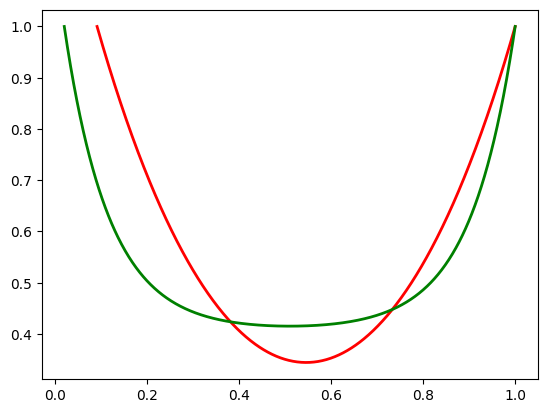

In [ ]:
# Plot analytical curves
for L2, c, label in zip(lengths, colors, labels):
    m_values = np.linspace(1, L2, 1000)
    T0_values = [calculate_T0(L2, m) for m in m_values]
    x2 = m_values / L2
    y2 = T0_values / np.max(T0_values)
    plt.plot(x2, y2, color=c, linestyle='-', linewidth=2)

In [ ]:
# MONTE CARLO SIMULATION
def simulate_search(L, target_pos, seed=None):
    if seed is not None:
        np.random.seed(seed)
    time = 0
    position = np.random.randint(0, L+1)  # Any random initial position

    while True:
        if position == 0:
            total_rate = k_on/L
            dt = np.log(1/np.random.rand()) / total_rate
            time += dt
            position = np.random.randint(0, L+1)
        else:
            if position == 1:
                total_rate = u + k_off
                dt = np.log(1/np.random.rand()) / total_rate
                time += dt
                r = np.random.rand()
                if r < k_off/total_rate:
                    position = 0
                else:
                    position += 1
            elif position == L:
                total_rate = u + k_off
                dt = np.log(1/np.random.rand()) / total_rate
                time += dt
                r = np.random.rand()
                if r < k_off/total_rate:
                    position = 0
                else:
                    position -= 1
            else:
                total_rate = 2*u + k_off
                dt = np.log(1/np.random.rand()) / total_rate
                time += dt
                r = np.random.rand()
                if r < u/total_rate:
                    position -= 1
                elif r < 2*u/total_rate:
                    position += 1
                else:
                    position = 0

        if position == target_pos:
            return time

def run_simulation(L, trials=n_trials):
    times = []
    target_positions = np.arange(1, L+1)
    for target in tqdm(target_positions, desc=f"Simulating L={L}"):
        trial_times = [simulate_search(L, target) for _ in range(trials)]
        avg_time = np.mean(trial_times)
        times.append(avg_time)
    return target_positions / L, np.array(times) / np.max(times)

Simulating L=51: 100%|██████████| 51/51 [10:42<00:00, 12.60s/it]


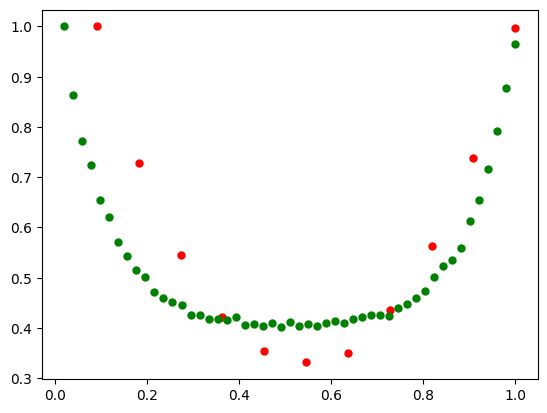

In [ ]:
# Plot simulation results
for L, c, label in zip(lengths, colors, labels):
    x, y = run_simulation(L)
    plt.plot(x, y, c+'o', markersize=5, label=f'Simulation {label}')

Simulating L=51: 100%|██████████| 51/51 [10:43<00:00, 12.62s/it]


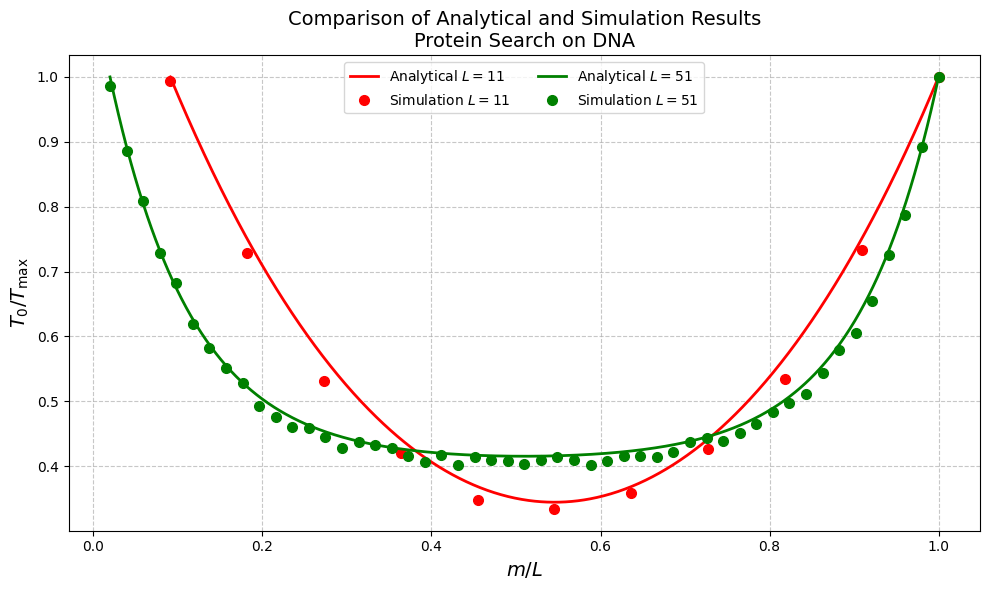

In [ ]:
# Final plot settings
plt.figure(figsize=(10, 6))

# Plot all analytical and simulation results together
for L, c, label in zip(lengths, colors, labels):
    # Plot analytical curve
    m_values = np.linspace(1, L, 1000)
    T_values = [calculate_T0(L, m) for m in m_values]
    x2 = m_values / L
    y2 = T_values / np.max(T_values)
    plt.plot(x2, y2, color=c, linewidth=2, label=f'Analytical {label}')

    # Plot simulation points
    x, y = run_simulation(L)
    plt.plot(x, y, c+'o', markersize=7, label=f'Simulation {label}')

plt.xlabel(r"$m/L$", fontsize=14)
plt.ylabel(r"$T_0/T_{\max}$", fontsize=14)
plt.title("Comparison of Analytical and Simulation Results\nProtein Search on DNA", fontsize=14)
plt.legend(fontsize=10, ncol=2, loc='upper center')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()